Import of necessary libraries

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import time
import re
import warnings
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import logging
import os
import json
import joblib

logging.set_verbosity_error()
warnings.filterwarnings('ignore')
seed = 42

Dataset clean (only once)

In [41]:
dataset= pd.read_csv("explaination_toxic_conversation_most_toxic_sentences.csv",header=0,encoding='utf-8')
dataset = dataset[dataset['explaination'].str.contains("La frase più tossica è", na=False)]
# Add a new column 'toxic' with value 1 for all rows
dataset['toxic'] = 1

non_toxic_dataset= pd.read_csv("generated_dataset.csv",header=0,encoding='utf-8')
# Concatenate the two datasets
dataset = pd.concat([dataset, non_toxic_dataset], ignore_index=False)

def validate_conversation_format(conversation):
    """
    Validates the format of a conversation string with more lenient criteria.
    """
    if pd.isna(conversation) or not isinstance(conversation, str):
        return False
    
    # Find all messages enclosed in double quotes
    message_pattern = r'"([^"]*)"'
    messages = re.findall(message_pattern, conversation)
    
    # Need at least 2 messages
    if len(messages) < 2:
        return False
    
    # Check that quotes are even numbered
    quote_count = conversation.count('"')
    if quote_count % 2 != 0:
        return False
    
    # Count valid messages (at least some content, not just empty or single chars)
    valid_messages = 0
    for msg in messages:
        cleaned_msg = msg.strip()
        if len(cleaned_msg) >= 2:  # Ridotto da 3 a 2 caratteri
            valid_messages += 1
    
    # Need at least 2 valid messages (più permissivo)
    return valid_messages >= 2

def clean_and_reconstruct_conversation(conversation):
    """
    Extract messages from conversation with more lenient cleaning.
    """
    if pd.isna(conversation) or not isinstance(conversation, str):
        return ""
    
    # Extract all messages enclosed in double quotes
    message_pattern = r'"([^"]*)"'
    messages = re.findall(message_pattern, conversation)
    
    if len(messages) < 2:
        return ""
    
    # Clean each message with more lenient criteria
    clean_messages = []
    for msg in messages:
        cleaned_msg = msg.strip()
        # Solo filtri basilari: almeno 2 caratteri e non solo spazi
        if len(cleaned_msg) >= 2 and not cleaned_msg.isspace():
            clean_messages.append(f'"{cleaned_msg}"')
    
    # Need at least 2 valid messages
    if len(clean_messages) < 2:
        return ""
    
    # Reconstruct conversation
    return " ".join(clean_messages)

print(f"Original dataset size: {len(dataset)}")

# Step 1: Initial validation and cleaning - PIU' PERMISSIVO
print("🧹 Cleaning and normalizing conversations...")
dataset = dataset.dropna(subset=['conversation'])

# Prima conta quante conversazioni ci sono
initial_count = len(dataset)
print(f"Conversations before validation: {initial_count}")

# Applica validazione più permissiva
valid_mask = dataset['conversation'].apply(validate_conversation_format)
dataset = dataset[valid_mask].copy()

print(f"Rows after format validation: {len(dataset)}")
print(f"Rows removed due to invalid format: {initial_count - len(dataset)}")

# Step 2: Clean and reconstruct conversations
print("\n🔧 Cleaning conversations...")
dataset['conversation_clean'] = dataset['conversation'].apply(clean_and_reconstruct_conversation)

# Remove rows where conversation cleaning failed
before_cleaning = len(dataset)
dataset_clean = dataset[dataset['conversation_clean'] != ""].copy()
print(f"Rows after conversation cleaning: {len(dataset_clean)}")
print(f"Rows removed due to cleaning issues: {before_cleaning - len(dataset_clean)}")

# Replace original conversation with clean version
dataset_clean['conversation'] = dataset_clean['conversation_clean']
dataset_clean = dataset_clean.drop('conversation_clean', axis=1)

# Step 3: Show examples of cleaning
print(f"\n📋 Examples of conversation normalization:")
for i in range(min(3, len(dataset_clean))):
    original = dataset.iloc[i]['conversation'] if i < len(dataset) else "N/A"
    clean = dataset_clean.iloc[i]['conversation']
    
    print(f"\nExample {i+1}:")
    print(f"Original: {original[:100]}...")
    print(f"Cleaned:  {clean[:100]}...")

# Update dataset
dataset = dataset_clean
print(f"\n🎯 Final cleaned dataset: {len(dataset)} conversations")
print(f"📊 Data retention: {len(dataset)/initial_count*100:.1f}% of original conversations kept")

# Save the cleaned dataset
dataset.to_csv("filtered_dataset.csv", index=False, encoding='utf-8')
print(f"💾 Dataset saved as 'filtered_dataset.csv'")

Original dataset size: 1475
🧹 Cleaning and normalizing conversations...
Conversations before validation: 1475
Rows after format validation: 857
Rows removed due to invalid format: 618

🔧 Cleaning conversations...
Rows after conversation cleaning: 857
Rows removed due to cleaning issues: 0

📋 Examples of conversation normalization:

Example 1:
Original: 1. "Hai assolutamente ragione. Sei così unico e speciale. Nessuno è mai stato come te. È incredibile...
Cleaned:  "Hai assolutamente ragione. Sei così unico e speciale. Nessuno è mai stato come te. È incredibile co...

Example 2:
Original: 1. Ubaldo: "Sono arrabbiata perché ti sei ubriacato e mi hai insultata davanti a tutti. Sembri compl...
Cleaned:  "Sono arrabbiata perché ti sei ubriacato e mi hai insultata davanti a tutti. Sembri completamente in...

Example 3:
Original: Renetto          "Scusa, ma non è che stai dicendo sempre la stessa cosa, no? Non sei mai felice, no...
Cleaned:  "Scusa, ma non è che stai dicendo sempre la stessa 

# BINARY CLASSIFICATION : Toxic or not #


# First Attempt: Pre-processing

In this section, we perform binary classification to determine whether a conversation is toxic or not. some pre-processing steps are applied. We apply TF-IDF vectorization directly to the conversation text and train a Logistic Regression model with hyperparameter tuning through nested cross-validation.

The model evaluates the following metrics:
- Accuracy
- F1 Score
- Precision
- Recall

The confusion matrix visualizes the model's performance in distinguishing between toxic and non-toxic conversations.

### Let's apply a pre-processing pipeline for text ###

Dataset shape: (857, 3314)
Training set shape: (599, 3314)
Test set shape: (258, 3314)

Best parameters found: {'C': 10, 'max_iter': 100, 'penalty': 'l2'}
Best cross-validation F1 score: 0.9967
Time taken for training and evaluation:: 27.18 seconds
Test Accuracy: 1.0000
Test F1-Score: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000

Best parameters found: {'C': 10, 'max_iter': 100, 'penalty': 'l2'}
Best cross-validation F1 score: 0.9967
Time taken for training and evaluation:: 27.18 seconds
Test Accuracy: 1.0000
Test F1-Score: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000


Dataset shape: (857, 3314)
Training set shape: (599, 3314)
Test set shape: (258, 3314)

Best parameters found: {'C': 10, 'max_iter': 100, 'penalty': 'l2'}
Best cross-validation F1 score: 0.9967
Time taken for training and evaluation:: 27.18 seconds
Test Accuracy: 1.0000
Test F1-Score: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000

Best parameters found: {'C': 10, 'max_iter': 100, 'penalty': 'l2'}
Best cross-validation F1 score: 0.9967
Time taken for training and evaluation:: 27.18 seconds
Test Accuracy: 1.0000
Test F1-Score: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.6s finished


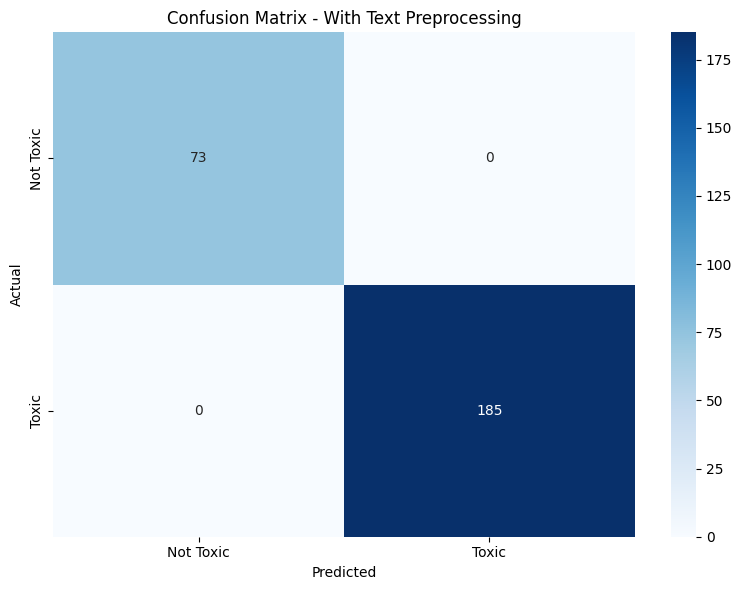

<Figure size 640x480 with 0 Axes>

In [68]:
#load the Italian language model for spaCy
# If you haven't installed the Italian model yet, you can do so with:
# !python -m spacy download it_core_news_sm
nlp = spacy.load('it_core_news_sm')

def preprocess_italian_text(text):
    """Italian text preprocessing function that tokenizes, lemmatizes, and removes stopwords"""
    if pd.isna(text):
        return ""
    
    # Convert text to string and lowercase
    text = str(text).lower()
    
    # Process the text with spaCy. Doc is a spaCy object that contains the processed text
    doc = nlp(text)
    
    # Initialize an empty list to hold processed tokens
    processed_tokens = []
    for token in doc:
        # Check if the token is not a stop word, punctuation, space, or a number
        if (not token.is_stop and 
            not token.is_punct and 
            not token.is_space and 
            not token.like_num):
            # Append the lemmatized token to the processed tokens list
            processed_tokens.append(token.lemma_)
    
    return " ".join(processed_tokens)

dataset=pd.read_csv("filtered_dataset.csv",header=0, encoding='utf-8')
#set seed for reproducibility
sklearn.utils.check_random_state(seed)
#shuffle the dataset
dataset = dataset.sample(frac=1, random_state=seed)
X = dataset['conversation']
y = dataset['toxic']

start_time = time.time()
# Apply an italian tokenizer, lemmatizer, and stop words
X_preprocessed = X.apply(preprocess_italian_text)

#Let's apply the TF-IDF vectorizer to the conversation data
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X_preprocessed)
#Now we can split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.3, random_state=seed)

print(f"Dataset shape: {X_vectorized.shape}")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

#Let's search for the best hyperparameters for the Logistic Regression model using a Nested Cross-Validation approach
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2', 'l1'],
    'max_iter': [100, 200, 500],
}

inner_cv = 5  # 5-fold cross-validation for hyperparameter tuning
outer_cv = 5  # 5-fold cross-validation for model evaluation

# Create the model
logistic_model = LogisticRegression(random_state=seed, solver='liblinear')

# Create GridSearchCV object for inner loop
grid_search = GridSearchCV(logistic_model, param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1, verbose=0)

# Outer loop: cross-validation for unbiased performance estimation
nested_scores = cross_val_score(grid_search, X_train, y_train, cv=outer_cv, scoring='f1', verbose=1)

# Fit the grid search on the entire training set to get the best parameters
grid_search.fit(X_train, y_train)
print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")

# Now we can train the final model with the best parameters found
final_model = LogisticRegression(**grid_search.best_params_, random_state=seed, solver='liblinear')
final_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
end_time = time.time()
print(f"Time taken for training and evaluation:: {end_time - start_time:.2f} seconds")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Create a confusion matrix with labels

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Toxic', 'Toxic'], 
            yticklabels=['Not Toxic', 'Toxic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - With Text Preprocessing')
plt.tight_layout()
plt.savefig('confusion_matrix_with_text_preprocessing.png')
plt.show()


## What if we don't apply any pre-processing? ##

Dataset shape: (857, 4585)
Training set shape: (599, 4585)
Test set shape: (258, 4585)


Dataset shape: (857, 4585)
Training set shape: (599, 4585)
Test set shape: (258, 4585)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


Dataset shape: (857, 4585)
Training set shape: (599, 4585)
Test set shape: (258, 4585)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished



Best parameters found: {'C': 1, 'max_iter': 100, 'penalty': 'l2'}
Best cross-validation F1 score: 0.9967
Time taken for training and evaluation: 0.84 seconds
Test Accuracy: 1.0000
Test F1-Score: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000


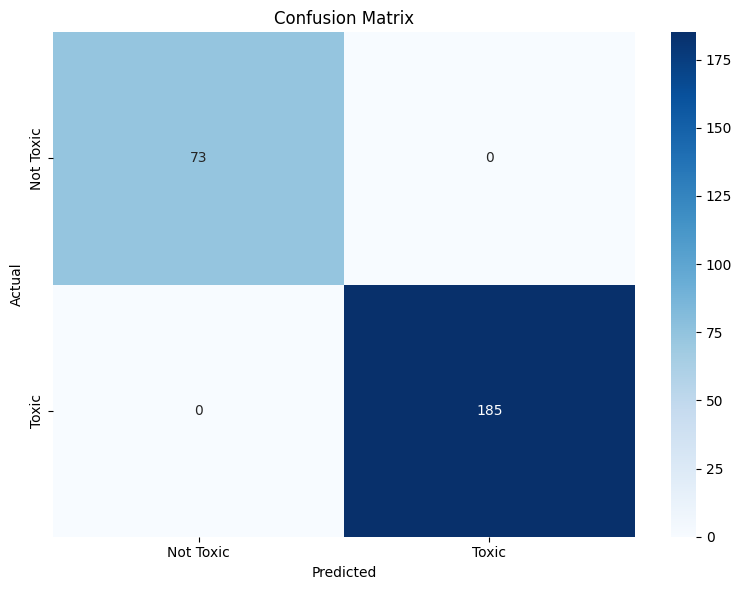

<Figure size 640x480 with 0 Axes>

In [69]:
dataset=pd.read_csv("filtered_dataset.csv",header=0, encoding='utf-8')
#set seed for reproducibility
sklearn.utils.check_random_state(seed)
#shuffle the dataset
dataset = dataset.sample(frac=1, random_state=seed)
#take 70% of the dataset for training and 30% for testing
#X contains the conversation, y contains the toxic label
X = dataset['conversation']
y = dataset['toxic']

init_time = time.time()
#Let's apply the TF-IDF vectorizer to the conversation data
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)
#Now we can split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.3, random_state=seed)

print(f"Dataset shape: {X_vectorized.shape}")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

#Let's search for the best hyperparameters for the Logistic Regression model using a Nested Cross-Validation approach
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2', 'l1'],
    'max_iter': [100, 200, 500],
}


inner_cv = 5  # 5-fold cross-validation for hyperparameter tuning
outer_cv = 5  # 5-fold cross-validation for model evaluation

# Create the model
logistic_model = LogisticRegression(random_state=seed, solver='liblinear')

# Create GridSearchCV object for inner loop
grid_search = GridSearchCV(logistic_model, param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1, verbose=0)



# Outer loop: cross-validation for unbiased performance estimation
nested_scores = cross_val_score(grid_search, X_train, y_train, cv=outer_cv, scoring='f1', verbose=1)



# Fit the grid search on the entire training set to get the best parameters
grid_search.fit(X_train, y_train)
print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")

# Now we can train the final model with the best parameters found
final_model = LogisticRegression(**grid_search.best_params_, random_state=seed, solver='liblinear')
final_model.fit(X_train, y_train)


# Make predictions on the test set
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

final_time = time.time()
print(f"Time taken for training and evaluation: {final_time - init_time:.2f} seconds")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")




# Create a confusion matrix with labels

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Toxic', 'Toxic'], 
            yticklabels=['Not Toxic', 'Toxic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix_without_text_preprocessing.png')
plt.show()



## Conclusion ##

In this analysis, we performed binary classification to detect toxic conversations using two approaches: one without text preprocessing and one with Italian language-specific preprocessing (tokenization, lemmatization, and stopword removal).

**Key Findings:**

Both models achieved remarkably similar performance metrics:

- **Without preprocessing**: Accuracy: 100%, F1-Score: 100%, Precision: 100%, Recall: 100% (Training time: ~1 second)
- **With preprocessing**: Accuracy: 100%, F1-Score: 100%, Precision: 100%, Recall: 100% (Training time: ~22 seconds)

**Performance Analysis:**

The results demonstrate that both approaches yield virtually identical classification performance, with perfect scores across all metrics. However, there is a significant difference in computational efficiency:

- The preprocessing pipeline requires approximately **20 times more computational time** than the raw text approach
- Both models achieve perfect classification on the test set, suggesting that the dataset may be well-separated or that the features are highly discriminative

**Practical Implications:**

Given these results, the text preprocessing step appears to be unnecessary for this particular dataset and classification task. The raw text approach provides:
- Equivalent predictive performance
- Substantial computational savings
- Reduced implementation complexity
- Lower resource requirements


# Conversation TAGGING with BERT #

### Let's load and clean our dataset ###

Only needed once

In [41]:
dataset=pd.read_csv("filtered_dataset.csv",header=0, encoding='utf-8')
print("Number of rows in the dataset:", len(dataset))

def extract_personality_types(person_couple):
    """
    Extract the personality types from the given couple string.
    """
    personality_mapping = {
        'Psicopatico e Adulatrice': ('Psicopatico', 'Adulatrice'),
        'Manipolatore e Dipendente emotiva': ('Manipolatore', 'Dipendente emotiva'),
        'Persona violenta e Succube': ('Persona violenta', 'Succube'),
        'Narcisista e Succube': ('Narcisista', 'Succube'),
        'Sadico-Crudele e Masochista': ('Sadico-Crudele', 'Masochista'),
        'Perfezionista Critico e Insicura Cronica': ('Perfezionista Critico', 'Insicura Cronica'),
        'Vittimista e Croccerossina': ('Vittimista', 'Croccerossina'),
        'Dominante e Schiavo emotivo': ('Dominante', 'Schiavo emotivo'),
        'Geloso-Ossessivo e Sottomessa': ('Geloso-Ossessivo', 'Sottomessa'),
        'Controllore e Isolata': ('Controllore', 'Isolata'),
        'Preoccupato e Rassicurante': ('Preoccupato', 'Rassicurante'),
        'Entusiasta e Sostenitore': ('Entusiasta', 'Sostenitore'),
        'Affettuoso e Rispettoso': ('Affettuoso', 'Rispettoso'),
        'Tranquillo e Confortante': ('Tranquillo', 'Confortante')
    }
    
    return personality_mapping.get(person_couple, (None, None))

def create_personality_tokens(personality_type):
    """
    Create a simple token for a given personality type.
    The token is formatted as [PERSONALITY].
    """
    # Normalize personality name to create valid token
    clean_personality = personality_type.replace(' ', '_').replace('-', '_').upper()
    token = f"[{clean_personality}]"
    return token

def clean_and_reconstruct_conversation(conversation):
    """
    Extract messages from conversation and reconstruct it cleanly with only alternating quoted messages.
    """
    if pd.isna(conversation) or not isinstance(conversation, str):
        return ""
    
    # Extract all messages enclosed in double quotes
    message_pattern = r'"([^"]*)"'
    messages = re.findall(message_pattern, conversation)
    
    if len(messages) < 2:
        return ""
    
    # Clean each message and filter out empty ones
    clean_messages = []
    for msg in messages:
        cleaned_msg = msg.strip()
        if cleaned_msg:  # Only keep non-empty messages
            clean_messages.append(f'"{cleaned_msg}"')
    
    # Reconstruct conversation with clean alternating messages
    return " ".join(clean_messages)

def tag_conversation_with_personalities(conversation, person_couple):
    """
    Apply personality tagging to a conversation based on the given person_couple.
    Returns None if tagging fails to ensure data consistency.
    """
    # Extract personality types
    personality1, personality2 = extract_personality_types(person_couple)
    
    if personality1 is None or personality2 is None:
        return None  # Return None instead of original conversation
    
    # Create tokens for both personalities
    token1 = create_personality_tokens(personality1)
    token2 = create_personality_tokens(personality2)
    
    # Extract all messages from conversation
    message_pattern = r'"([^"]*)"'
    messages = re.findall(message_pattern, conversation)
    
    if len(messages) < 2:
        return None  # Return None if not enough messages
    
    # Build tagged conversation
    tagged_messages = []
    
    for i, message in enumerate(messages):
        message = message.strip()
        
        # Alternate between personalities (0,2,4... = personality1; 1,3,5... = personality2)
        if i % 2 == 0:
            # Message from first personality - TAG ALLA FINE
            tagged_message = f"{message} {token1}"
        else:
            # Message from second personality - TAG ALLA FINE
            tagged_message = f"{message} {token2}"
        
        tagged_messages.append(tagged_message)
    
    return " ".join(tagged_messages)


print(f"Original rows: {len(dataset)}")
print(f"Rows after initial cleaning: {len(dataset)}")
print(f"Rows removed: {len(dataset) - len(dataset)}")

# Step 2: Check personality couple mapping
print(f"\n🔍 Checking personality couple mapping...")
unique_couples = dataset['person_couple'].unique()
unmapped_couples = []

for couple in unique_couples:
    personality1, personality2 = extract_personality_types(couple)
    if personality1 is None or personality2 is None:
        unmapped_couples.append(couple)

if unmapped_couples:
    print(f"❌ Found {len(unmapped_couples)} unmapped personality couples:")
    for couple in unmapped_couples:
        print(f"   - {couple}")
    print("These will be excluded from the final dataset!")
else:
    print(f"✅ All {len(unique_couples)} personality couples are properly mapped")

# Show distribution of personality couples
print(f"\n📊 Personality couple distribution:")
couple_counts = dataset['person_couple'].value_counts()
for couple, count in couple_counts.items():
    print(f"   - {couple}: {count} conversations")

# Step 3: Clean and reconstruct conversations
print(f"\n🔧 Cleaning and reconstructing conversations...")
dataset['conversation_clean'] = dataset['conversation'].apply(clean_and_reconstruct_conversation)

# Remove rows where conversation cleaning failed
before_conv_cleaning = len(dataset)
dataset = dataset[dataset['conversation_clean'] != ""].copy()
print(f"Rows after conversation cleaning: {len(dataset)}")
print(f"Rows removed due to conversation issues: {before_conv_cleaning - len(dataset)}")

# Replace original conversation with clean version
dataset['conversation'] = dataset['conversation_clean']
dataset = dataset.drop('conversation_clean', axis=1)

# Step 4: Apply personality tagging
print(f"\n🏷️ Adding personality tokens...")
dataset['tagged_conversation'] = dataset.apply(
    lambda row: tag_conversation_with_personalities(row['conversation'], row['person_couple']), 
    axis=1
)

# Step 5: Filter out failed tagging
before_tagging_filter = len(dataset)
dataset_final = dataset[dataset['tagged_conversation'].notna()].copy()
print(f"Rows after filtering failed tagging: {len(dataset_final)}")
print(f"Rows removed due to tagging failures: {before_tagging_filter - len(dataset_final)}")

# Step 6: Quality check and examples
if len(dataset_final) > 0:
    print(f"\n✅ Example of cleaned and tagged conversation:")
    sample_row = dataset_final.iloc[0]
    print(f"Couple: {sample_row['person_couple']}")
    print(f"Clean conversation: {sample_row['conversation'][:150]}...")
    print(f"Tagged conversation: {sample_row['tagged_conversation'][:200]}...")
    
    # Show token verification - AGGIORNATO
    print(f"\n🔍 Token verification for first conversation:")
    tokens_found = re.findall(r'\[[A-Z_]+\]', sample_row['tagged_conversation'])
    print(f"Tokens found: {tokens_found}...")  
else:
    print("❌ No valid conversations after processing!")

# Step 7: Final dataset preparation
dataset = dataset_final
print(f"\n🎯- Total conversations: {len(dataset)}")

# Keep only the required columns
dataset = dataset[['conversation', 'tagged_conversation', 'toxic']]

# Step 8: Save dataset
dataset.to_csv("dataset_clean_with_personality_tags.csv", index=False, encoding='utf-8')
print(f"💾 Dataset saved as 'dataset_clean_with_personality_tags.csv'")

Number of rows in the dataset: 857
Original rows: 857
Rows after initial cleaning: 857
Rows removed: 0

🔍 Checking personality couple mapping...
✅ All 14 personality couples are properly mapped

📊 Personality couple distribution:
   - Geloso-Ossessivo e Sottomessa: 86 conversations
   - Affettuoso e Rispettoso: 78 conversations
   - Manipolatore e Dipendente emotiva: 73 conversations
   - Sadico-Crudele e Masochista: 69 conversations
   - Perfezionista Critico e Insicura Cronica: 68 conversations
   - Tranquillo e Confortante: 66 conversations
   - Preoccupato e Rassicurante: 65 conversations
   - Vittimista e Croccerossina: 64 conversations
   - Narcisista e Succube: 57 conversations
   - Entusiasta e Sostenitore: 55 conversations
   - Persona violenta e Succube: 50 conversations
   - Psicopatico e Adulatrice: 45 conversations
   - Controllore e Isolata: 44 conversations
   - Dominante e Schiavo emotivo: 37 conversations

🔧 Cleaning and reconstructing conversations...
Rows after conve

# Now let's use BERT #

Dataset loaded: 857 conversations

🔄 Splitting dataset...
🖥️ Utilizzo dispositivo: cuda
🚀 Model loaded on cuda:0
🚀 Starting batch processing...
Processing batch 1/9
Conversations 1-32/258
Completed 32/258 conversations

Processing batch 2/9
Conversations 33-64/258
Completed 64/258 conversations

Processing batch 3/9
Conversations 65-96/258
Completed 96/258 conversations

Processing batch 4/9
Conversations 97-128/258
Completed 128/258 conversations

Processing batch 5/9
Conversations 129-160/258
Completed 160/258 conversations

Processing batch 6/9
Conversations 161-192/258
Completed 192/258 conversations

Processing batch 7/9
Conversations 193-224/258
Completed 224/258 conversations

Processing batch 8/9
Conversations 225-256/258
Completed 256/258 conversations

Processing batch 9/9
Conversations 257-258/258
Completed 258/258 conversations


🎯 Results of Zero-Shot Batch Processing

Accuracy: 0.0268
Macro Precision: 0.0010
Macro Recall: 0.0364
Macro F1-Score: 0.0020


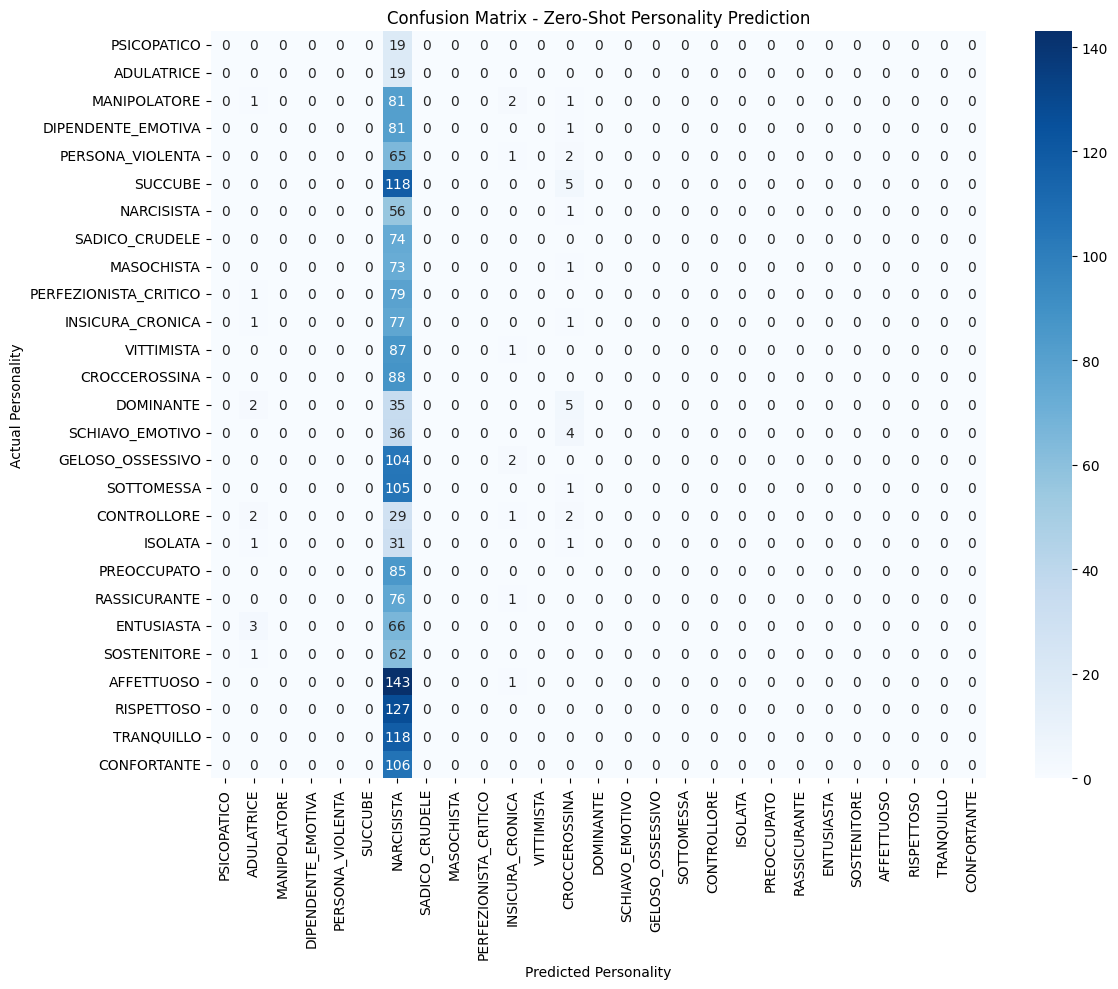

<Figure size 640x480 with 0 Axes>

In [58]:
# Load dataset
dataset = pd.read_csv("dataset_clean_with_personality_tags.csv", encoding='utf-8')
print(f"Dataset loaded: {len(dataset)} conversations")

# Split dataset into train and test sets
print(f"\n🔄 Splitting dataset...")
X_train, X_test, y_train, y_test = train_test_split(
    dataset['conversation'],   #this will be used for training
    dataset['tagged_conversation'], # this will be the target
    test_size=0.3,
    random_state=seed,
    shuffle=True
)

# Define personality types with detailed descriptions
personality_descriptions = {
    'PSICOPATICO': "Una persona che manipola senza empatia in modo freddo e calcolato",
    'ADULATRICE': "Una persona che elogia eccessivamente, lusinga in modo servile e compiacente per ottenere favori", 
    'MANIPOLATORE': "Una persona che manipola psicologicamente gli altri per ottenere vantaggi personali",
    'DIPENDENTE_EMOTIVA': "Una persona che dipende eccessivamente dagli altri per il supporto emotivo e la validazione",
    'PERSONA_VIOLENTA': "Una persona che usa aggressività verbale, minacce o comportamenti intimidatori",
    'SUCCUBE': "Una persona completamente dominata e sottomessa, che subisce senza reagire",
    'NARCISISTA': "Una persona con senso grandioso di sé, mancanza di empatia e bisogno di ammirazione",
    'SADICO_CRUDELE': "Una persona che trae piacere dal causare sofferenza fisica o psicologica altrui",
    'MASOCHISTA': "Una persona che cerca o accetta sofferenza, umiliazione e trattamenti negativi",
    'PERFEZIONISTA_CRITICO': "Una persona che critica tutto e ha standard impossibili da raggiungere",
    'INSICURA_CRONICA': "Una persona che mostra insicurezza costante, mancanza di autostima e bisogno di rassicurazione",
    'VITTIMISTA': "Una persona che si presenta sempre come vittima delle circostanze",
    'CROCCEROSSINA': "Una persona che ha un bisogno compulsivo di salvare e aiutare gli altri, anche quando non richiesto",
    'DOMINANTE': "Una persona che impone la propria volontà in modo autoritario e aggressivo",
    'SCHIAVO_EMOTIVO': "Una persona completamente sottomessa emotivamente, senza autonomia personale",
    'GELOSO_OSSESSIVO': "Una persona che manifesta gelosia patologica e comportamenti ossessivi possessivi",
    'SOTTOMESSA': "Una persona che si sottomette passivamente agli altri senza esprimere opinioni proprie",
    'CONTROLLORE': "Una persona che cerca di dominare e controllare gli altri in modo manipolativo e autoritario",
    'ISOLATA': "Una persona che si ritira socialmente, evita il contatto e preferisce la solitudine",
    'PREOCCUPATO': "Una persona che mostra ansia, preoccupazione e stress costanti",
    'RASSICURANTE': "Una persona che tranquillizza e conforta gli altri in modo sano e costruttivo",
    'ENTUSIASTA': "Una persona che mostra energia, passione e entusiasmo positivi",
    'SOSTENITORE': "Una persona che supporta gli altri in modo costruttivo, sano e incoraggiante",
    'AFFETTUOSO': "Una persona che mostra calore, tenerezza e affetto genuino verso gli altri",
    'RISPETTOSO': "Una persona che mostra considerazione, cortesia e rispetto genuino per gli altri",
    'TRANQUILLO': "Una persona calma, equilibrata emotivamente e pacifica",
    'CONFORTANTE': "Una persona che offre consolazione, supporto emotivo e comfort agli altri"
}

personality_types = list(personality_descriptions.keys())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Utilizzo dispositivo: {device}")

model_name = "dbmdz/bert-base-italian-xxl-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# We need to add personality tokens to the tokenizer
personality_tokens = [f"[{personality}]" for personality in personality_types]
tokenizer.add_tokens(personality_tokens)

# Since we added new tokens, we need to resize the model's token embeddings
model.resize_token_embeddings(len(tokenizer))

model = model.to(device)
model.eval()  # Set model to evaluation mode since we are not training it

print(f"🚀 Model loaded on {next(model.parameters()).device}")

def extract_messages_from_conversation(conversation):
    """Extracts messages from a conversation string."""
    if pd.isna(conversation) or not isinstance(conversation, str):
        return []
    message_pattern = r'"([^"]*)"'
    messages = re.findall(message_pattern, conversation)
    clean_messages = [msg.strip() for msg in messages if msg.strip()]
    return clean_messages

def extract_target_tags(tagged_conversation):
    """Extracts personality tags from a tagged conversation string."""
    if pd.isna(tagged_conversation) or not isinstance(tagged_conversation, str):
        return []
    tag_pattern = r'\[([A-Z_]+)\]'
    tags = re.findall(tag_pattern, tagged_conversation)    
    return tags

def create_zero_shot_prompt_with_personalities(message, conversation_context, personality_descriptions):
    """Create a zero-shot prompt that includes the conversation context and personality descriptions."""
    if conversation_context:
        context_parts = []
        for ctx in conversation_context:
            context_parts.append(f"{ctx['message']} [{ctx['personality']}]")
        context_text = " ".join(context_parts) + " " + message
    else:
        context_text = message
    
    # Crea le opzioni per le personalità
    personality_options = []
    for i, (personality, description) in enumerate(personality_descriptions.items()):
        personality_options.append(f"{i+1}. {personality}: {description}")
    
    options_text = "\n".join(personality_options)
    
    # Prompt semplificato che usa il CONTESTO CONCATENATO come input
    prompt = f"""Analizza il seguente testo e determina quale personalità descrive meglio l'ultimo messaggio:

Testo: "{context_text}"

Opzioni di personalità:
{options_text}

Quale personalità descrive meglio l'ultimo messaggio nel testo?
Rispondi solo con il nome della personalità (es. NARCISISTA).
"""
    return prompt

def predict_personality_batch(messages, personality_descriptions, model, tokenizer, batch_size=32):
    """Predicts personality types for a list of messages using batch processing."""
    predictions = []
    conversation_context = []
    device = next(model.parameters()).device
    
    # Pre-compute tutti gli embeddings delle descrizioni delle personalità
    personality_embeddings = {}
    desc_texts = []
    desc_personalities = []
    
    for personality, description in personality_descriptions.items():
        desc_texts.append(description)
        desc_personalities.append(personality)
    
    # Batch processing per le descrizioni
    for i in range(0, len(desc_texts), batch_size):
        batch_descs = desc_texts[i:i+batch_size]
        batch_personalities = desc_personalities[i:i+batch_size]
        
        desc_inputs = tokenizer(batch_descs, return_tensors="pt", 
                               truncation=True,
                               padding=True)
        desc_inputs = {k: v.to(device) for k, v in desc_inputs.items()}
        
        with torch.no_grad():
            desc_outputs = model(**desc_inputs)
            # Media pesata con attention mask
            desc_embeddings = desc_outputs.last_hidden_state
            attention_mask = desc_inputs['attention_mask'].unsqueeze(-1)
            masked_embeddings = desc_embeddings * attention_mask
            summed = torch.sum(masked_embeddings, dim=1)
            lengths = torch.sum(desc_inputs['attention_mask'], dim=1, keepdim=True)
            desc_embeddings_avg = summed / lengths
        
        for j, personality in enumerate(batch_personalities):
            personality_embeddings[personality] = desc_embeddings_avg[j].cpu()
    
    
    for i, message in enumerate(messages):
        
        prompt = create_zero_shot_prompt_with_personalities(
            message, conversation_context, personality_descriptions
        )
        
        
        inputs = tokenizer(prompt, return_tensors="pt", 
                          truncation=True,
                          padding=False)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        
        with torch.no_grad():
            outputs = model(**inputs)
            
            message_embeddings = outputs.last_hidden_state
            attention_mask = inputs['attention_mask'].unsqueeze(-1)
            masked_embeddings = message_embeddings * attention_mask
            summed = torch.sum(masked_embeddings, dim=1)
            lengths = torch.sum(inputs['attention_mask'], dim=1, keepdim=True)
            message_embedding = summed / lengths
        
        
        best_personality = None
        best_score = -float('inf')
        
        message_embedding_cpu = message_embedding.cpu()
        
        for personality, desc_embedding in personality_embeddings.items():
            similarity = F.cosine_similarity(message_embedding_cpu, 
                                           desc_embedding.unsqueeze(0), 
                                           dim=1).item()
            
            if similarity > best_score:
                best_score = similarity
                best_personality = personality
        
        predictions.append(best_personality)
        
        
        conversation_context.append({
            'message': message,
            'personality': best_personality
        })
        
    
    return predictions

def evaluate_zero_shot_predictions(predictions, targets):
    """Evaluates the accuracy of zero-shot predictions against the targets."""
    if len(predictions) != len(targets):
        print(f"Warning: Different lengths - predictions: {len(predictions)}, target: {len(targets)}")
        min_len = min(len(predictions), len(targets))
        predictions = predictions[:min_len]
        targets = targets[:min_len]
    
    correct = sum(1 for p, t in zip(predictions, targets) if p == t)
    total = len(targets)
    accuracy = correct / total if total > 0 else 0
    
    return accuracy, correct, total

def process_conversations_in_batches(X_test, y_test, batch_size=32):
    """Processes conversations in batches for zero-shot personality prediction."""
    all_predictions = []
    all_targets = []
    conversation_results = []
    
    total_conversations = len(X_test)
    processed = 0
    
    for idx in range(0, total_conversations, batch_size):
        batch_conversations = list(X_test)[idx:idx+batch_size]
        batch_tagged = list(y_test)[idx:idx+batch_size]
        
        print(f"Processing batch {idx//batch_size + 1}/{(total_conversations + batch_size - 1)//batch_size}")
        print(f"Conversations {idx+1}-{min(idx+batch_size, total_conversations)}/{total_conversations}")
        
        for i, (conversation, tagged_conversation) in enumerate(zip(batch_conversations, batch_tagged)):
            actual_idx = idx + i
            messages = extract_messages_from_conversation(conversation)
            targets = extract_target_tags(tagged_conversation)
            
            if len(messages) == 0 or len(targets) == 0:
                continue
                
            try:
                predictions = predict_personality_batch(
                    messages, personality_descriptions, model, tokenizer, batch_size=32
                )
                
                conv_accuracy, conv_correct, conv_total = evaluate_zero_shot_predictions(predictions, targets)
                
                conversation_results.append({
                    'conversation_id': actual_idx,
                    'accuracy': conv_accuracy,
                    'correct': conv_correct,
                    'total': conv_total,
                    'messages': len(messages)
                })
                
                all_predictions.extend(predictions)
                all_targets.extend(targets[:len(predictions)])
                
            except Exception as e:
                print(f"Error in conversation {actual_idx}: {e}")
                continue
        
        # Clear GPU memory to avoid OOM errors
        torch.cuda.empty_cache()
        processed += len(batch_conversations)
        print(f"Completed {processed}/{total_conversations} conversations\n")
    
    return all_predictions, all_targets, conversation_results

# Processing
print("🚀 Starting batch processing...")
all_predictions, all_targets, conversation_results = process_conversations_in_batches(
    X_test, y_test, batch_size=32
)

overall_accuracy, total_correct, total_messages = evaluate_zero_shot_predictions(all_predictions, all_targets)
macro_precision = precision_score(all_targets, all_predictions, average='macro', zero_division=0)
macro_recall = recall_score(all_targets, all_predictions, average='macro', zero_division=0)
macro_f1 = f1_score(all_targets, all_predictions, average='macro', zero_division=0)

print(f"\n🎯 Results of Zero-Shot Batch Processing\n")
print(f"Accuracy: {overall_accuracy:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")

confusion_matrix_result = confusion_matrix(all_targets, all_predictions, labels=personality_types)
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix_result, annot=True, fmt='d', cmap='Blues', 
            xticklabels=personality_types, yticklabels=personality_types)
plt.xlabel('Predicted Personality')
plt.ylabel('Actual Personality')
plt.title('Confusion Matrix - Zero-Shot Personality Prediction')
plt.tight_layout()
plt.show()
plt.savefig("confusion_matrix_zero_shot.png")

🚀 Starting Fine-tuning Approach with Early Stopping
Dataset loaded: 857 conversations

🔄 Splitting dataset...
🖥️ Device: cuda
📝 Preparing training data...
Training samples: 4703

🚀 Starting training for max 50 epochs with early stopping...
📊 Training samples: 3762
📊 Validation samples: 941
⏰ Patience: 10 epochs

📚 Epoch 1/50


Training Epoch 1: 100%|██████████| 236/236 [03:52<00:00,  1.01it/s, train_loss=3.6164]


Avg Training Loss: 3.1699
Avg Validation Loss: 2.6084
✅ New best model! Validation loss improved to 2.6084

📚 Epoch 2/50


Training Epoch 2: 100%|██████████| 236/236 [03:56<00:00,  1.00s/it, train_loss=1.4805]


Avg Training Loss: 2.2841
Avg Validation Loss: 1.8259
✅ New best model! Validation loss improved to 1.8259

📚 Epoch 3/50


Training Epoch 3: 100%|██████████| 236/236 [03:56<00:00,  1.00s/it, train_loss=2.4281]


Avg Training Loss: 1.5977
Avg Validation Loss: 1.2677
✅ New best model! Validation loss improved to 1.2677

📚 Epoch 4/50


Training Epoch 4: 100%|██████████| 236/236 [03:55<00:00,  1.00it/s, train_loss=0.5915]


Avg Training Loss: 1.0845
Avg Validation Loss: 0.9581
✅ New best model! Validation loss improved to 0.9581

📚 Epoch 5/50


Training Epoch 5: 100%|██████████| 236/236 [03:56<00:00,  1.00s/it, train_loss=1.0187]


Avg Training Loss: 0.8735
Avg Validation Loss: 0.8579
✅ New best model! Validation loss improved to 0.8579

📚 Epoch 6/50


Training Epoch 6: 100%|██████████| 236/236 [03:56<00:00,  1.00s/it, train_loss=0.8175]


Avg Training Loss: 0.7915
Avg Validation Loss: 0.8354
✅ New best model! Validation loss improved to 0.8354

📚 Epoch 7/50


Training Epoch 7: 100%|██████████| 236/236 [03:56<00:00,  1.00s/it, train_loss=0.3761]


Avg Training Loss: 0.7294
Avg Validation Loss: 0.8172
✅ New best model! Validation loss improved to 0.8172

📚 Epoch 8/50


Training Epoch 8: 100%|██████████| 236/236 [03:56<00:00,  1.00s/it, train_loss=0.4759]


Avg Training Loss: 0.6634
Avg Validation Loss: 0.7818
✅ New best model! Validation loss improved to 0.7818

📚 Epoch 9/50


Training Epoch 9: 100%|██████████| 236/236 [03:58<00:00,  1.01s/it, train_loss=1.3801]


Avg Training Loss: 0.5733
Avg Validation Loss: 0.7059
✅ New best model! Validation loss improved to 0.7059

📚 Epoch 10/50


Training Epoch 10: 100%|██████████| 236/236 [03:56<00:00,  1.00s/it, train_loss=0.6911]


Avg Training Loss: 0.4780
Avg Validation Loss: 0.6349
✅ New best model! Validation loss improved to 0.6349

📚 Epoch 11/50


Training Epoch 11: 100%|██████████| 236/236 [03:56<00:00,  1.00s/it, train_loss=0.5318]


Avg Training Loss: 0.3798
Avg Validation Loss: 0.5408
✅ New best model! Validation loss improved to 0.5408

📚 Epoch 12/50


Training Epoch 12: 100%|██████████| 236/236 [03:56<00:00,  1.00s/it, train_loss=0.0537]


Avg Training Loss: 0.2668
Avg Validation Loss: 0.3990
✅ New best model! Validation loss improved to 0.3990

📚 Epoch 13/50


Training Epoch 13: 100%|██████████| 236/236 [03:56<00:00,  1.00s/it, train_loss=0.0269]


Avg Training Loss: 0.1700
Avg Validation Loss: 0.2900
✅ New best model! Validation loss improved to 0.2900

📚 Epoch 14/50


Training Epoch 14: 100%|██████████| 236/236 [03:55<00:00,  1.00it/s, train_loss=0.0228]


Avg Training Loss: 0.1020
Avg Validation Loss: 0.2546
✅ New best model! Validation loss improved to 0.2546

📚 Epoch 15/50


Training Epoch 15: 100%|██████████| 236/236 [03:56<00:00,  1.00s/it, train_loss=0.0132]


Avg Training Loss: 0.0606
Avg Validation Loss: 0.2504
✅ New best model! Validation loss improved to 0.2504

📚 Epoch 16/50


Training Epoch 16: 100%|██████████| 236/236 [03:57<00:00,  1.00s/it, train_loss=0.0172]


Avg Training Loss: 0.0370
Avg Validation Loss: 0.2760
⏳ No improvement for 1/10 epochs

📚 Epoch 17/50


Training Epoch 17: 100%|██████████| 236/236 [03:56<00:00,  1.00s/it, train_loss=0.0050]


Avg Training Loss: 0.0372
Avg Validation Loss: 0.2795
⏳ No improvement for 2/10 epochs

📚 Epoch 18/50


Training Epoch 18: 100%|██████████| 236/236 [03:56<00:00,  1.00s/it, train_loss=0.0046]


Avg Training Loss: 0.0249
Avg Validation Loss: 0.2895
⏳ No improvement for 3/10 epochs

📚 Epoch 19/50


Training Epoch 19: 100%|██████████| 236/236 [03:57<00:00,  1.01s/it, train_loss=0.0032]


Avg Training Loss: 0.0197
Avg Validation Loss: 0.2955
⏳ No improvement for 4/10 epochs

📚 Epoch 20/50


Training Epoch 20: 100%|██████████| 236/236 [03:55<00:00,  1.00it/s, train_loss=0.0030]


Avg Training Loss: 0.0176
Avg Validation Loss: 0.3023
⏳ No improvement for 5/10 epochs

📚 Epoch 21/50


Training Epoch 21: 100%|██████████| 236/236 [03:56<00:00,  1.00s/it, train_loss=0.0025]


Avg Training Loss: 0.0214
Avg Validation Loss: 0.3025
⏳ No improvement for 6/10 epochs

📚 Epoch 22/50


Training Epoch 22: 100%|██████████| 236/236 [03:55<00:00,  1.00it/s, train_loss=0.0014]


Avg Training Loss: 0.0205
Avg Validation Loss: 0.3160
⏳ No improvement for 7/10 epochs

📚 Epoch 23/50


Training Epoch 23: 100%|██████████| 236/236 [03:56<00:00,  1.00s/it, train_loss=0.0021]


Avg Training Loss: 0.0241
Avg Validation Loss: 0.3337
⏳ No improvement for 8/10 epochs

📚 Epoch 24/50


Training Epoch 24: 100%|██████████| 236/236 [03:56<00:00,  1.00s/it, train_loss=0.0010]


Avg Training Loss: 0.0188
Avg Validation Loss: 0.3339
⏳ No improvement for 9/10 epochs

📚 Epoch 25/50


Training Epoch 25: 100%|██████████| 236/236 [03:56<00:00,  1.00s/it, train_loss=0.0012]


Avg Training Loss: 0.0181
Avg Validation Loss: 0.3409
⏳ No improvement for 10/10 epochs

🛑 Early stopping triggered after 25 epochs
🏆 Best validation loss: 0.2504

🏆 Loaded best model from epoch 15
📊 Best validation loss: 0.2504
✅ Training completed!

🧪 Testing fine-tuned model...
Processed 50/258 conversations
Processed 100/258 conversations
Processed 150/258 conversations
Processed 200/258 conversations
Processed 250/258 conversations

🎯 Results of Fine-tuned Model

Accuracy: 0.5628
Macro Precision: 0.5093
Macro Recall: 0.5043
Macro F1-Score: 0.5015


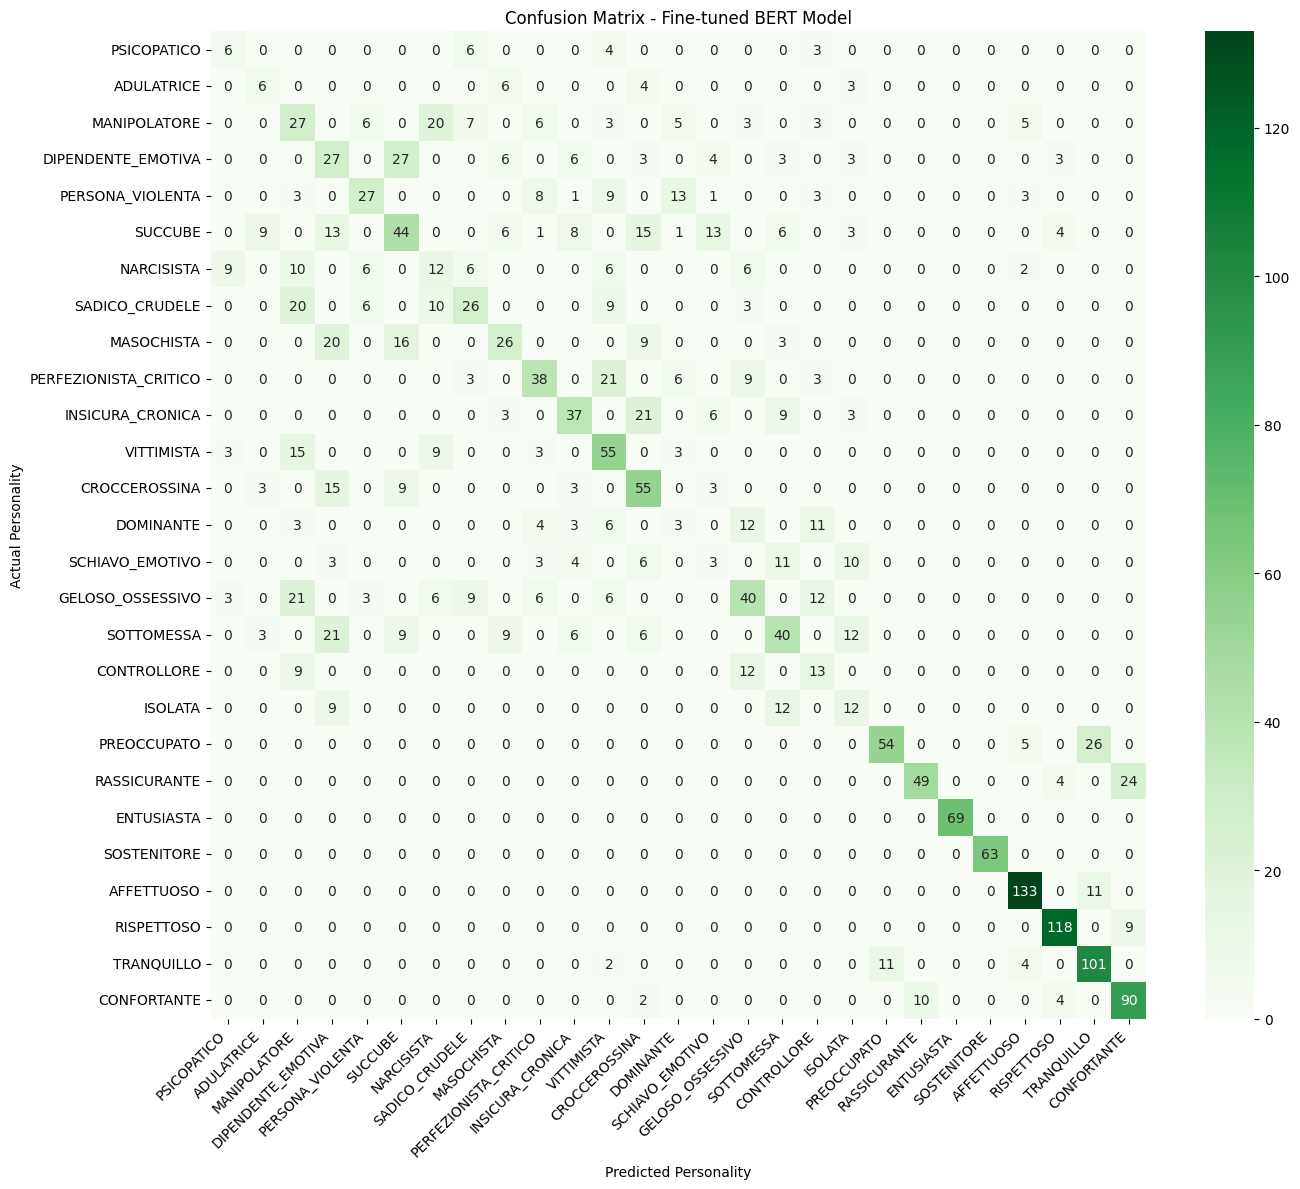

<Figure size 640x480 with 0 Axes>

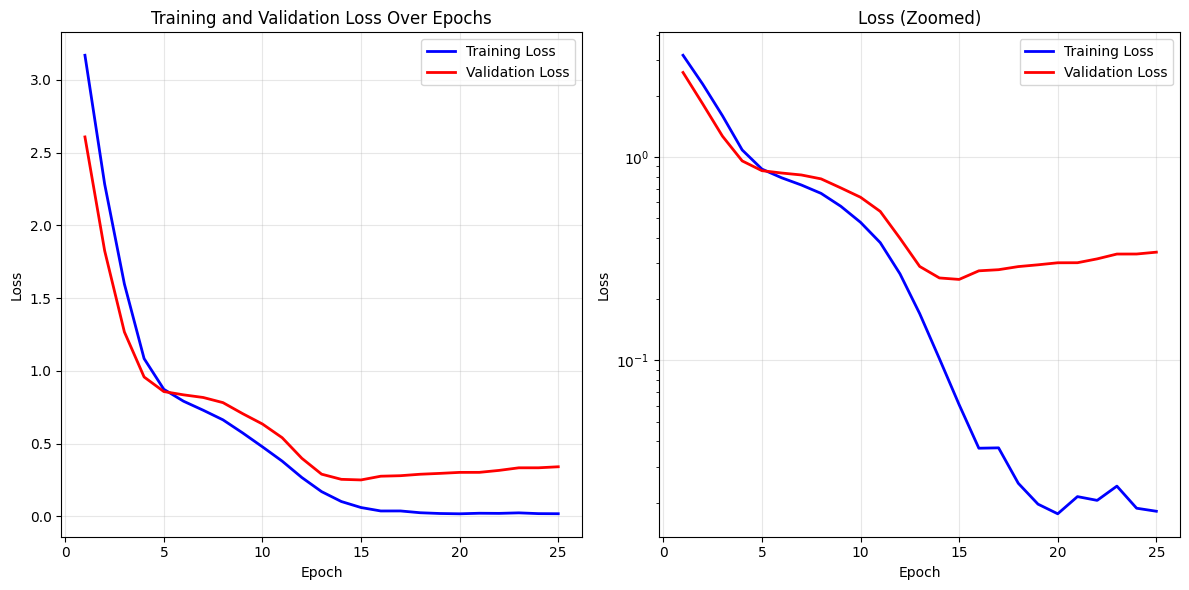

💾 Modello salvato in: personality_classifier_best
📊 Metadati salvati con 19 parametri

✅ Fine-tuning completed with early stopping!
📊 Best model achieved validation loss: 0.2504
🎯 Final test accuracy: 0.5628
💾 Model saved to: personality_classifier_best


<Figure size 640x480 with 0 Axes>

In [ ]:
print("🚀 Starting Fine-tuning Approach with Early Stopping")

# Load dataset (same as before)
dataset = pd.read_csv("dataset_clean_with_personality_tags.csv", encoding='utf-8')
print(f"Dataset loaded: {len(dataset)} conversations")

# Split dataset into train and test sets
print(f"\n🔄 Splitting dataset...")
X_train, X_test, y_train, y_test = train_test_split(
    dataset['conversation'],
    dataset['tagged_conversation'],
    test_size=0.3,
    random_state=seed,
    shuffle=True
)

# Define personality types (same as before)
personality_descriptions = {
    'PSICOPATICO': "Una persona che manipola senza empatia in modo freddo e calcolato",
    'ADULATRICE': "Una persona che elogia eccessivamente, lusinga in modo servile e compiacente per ottenere favori", 
    'MANIPOLATORE': "Una persona che manipola psicologicamente gli altri per ottenere vantaggi personali",
    'DIPENDENTE_EMOTIVA': "Una persona che dipende eccessivamente dagli altri per il supporto emotivo e la validazione",
    'PERSONA_VIOLENTA': "Una persona che usa aggressività verbale, minacce o comportamenti intimidatori",
    'SUCCUBE': "Una persona completamente dominata e sottomessa, che subisce senza reagire",
    'NARCISISTA': "Una persona con senso grandioso di sé, mancanza di empatia e bisogno di ammirazione",
    'SADICO_CRUDELE': "Una persona che trae piacere dal causare sofferenza fisica o psicologica altrui",
    'MASOCHISTA': "Una persona che cerca o accetta sofferenza, umiliazione e trattamenti negativi",
    'PERFEZIONISTA_CRITICO': "Una persona che critica tutto e ha standard impossibili da raggiungere",
    'INSICURA_CRONICA': "Una persona che mostra insicurezza costante, mancanza di autostima e bisogno di rassicurazione",
    'VITTIMISTA': "Una persona che si presenta sempre come vittima delle circostanze",
    'CROCCEROSSINA': "Una persona che ha un bisogno compulsivo di salvare e aiutare gli altri, anche quando non richiesto",
    'DOMINANTE': "Una persona che impone la propria volontà in modo autoritario e aggressivo",
    'SCHIAVO_EMOTIVO': "Una persona completamente sottomessa emotivamente, senza autonomia personale",
    'GELOSO_OSSESSIVO': "Una persona che manifesta gelosia patologica e comportamenti ossessivi possessivi",
    'SOTTOMESSA': "Una persona che si sottomette passivamente agli altri senza esprimere opinioni proprie",
    'CONTROLLORE': "Una persona che cerca di dominare e controllare gli altri in modo manipolativo e autoritario",
    'ISOLATA': "Una persona che si ritira socialmente, evita il contatto e preferisce la solitudine",
    'PREOCCUPATO': "Una persona che mostra ansia, preoccupazione e stress costanti",
    'RASSICURANTE': "Una persona che tranquillizza e conforta gli altri in modo sano e costruttivo",
    'ENTUSIASTA': "Una persona che mostra energia, passione e entusiasmo positivi",
    'SOSTENITORE': "Una persona che supporta gli altri in modo costruttivo, sano e incoraggiante",
    'AFFETTUOSO': "Una persona che mostra calore, tenerezza e affetto genuino verso gli altri",
    'RISPETTOSO': "Una persona che mostra considerazione, cortesia e rispetto genuino per gli altri",
    'TRANQUILLO': "Una persona calma, equilibrata emotivamente e pacifica",
    'CONFORTANTE': "Una persona che offre consolazione, supporto emotivo e comfort agli altri"
}

personality_types = list(personality_descriptions.keys())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Device: {device}")

# Load model and tokenizer
model_name = "dbmdz/bert-base-italian-xxl-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModel.from_pretrained(model_name)

# Add personality tokens to tokenizer
personality_tokens = [f"[{personality}]" for personality in personality_types]
tokenizer.add_tokens(personality_tokens)
base_model.resize_token_embeddings(len(tokenizer))

# Define Classification Model
class PersonalityClassifier(nn.Module):
    def __init__(self, base_model, num_classes, dropout_rate=0.3):
        super(PersonalityClassifier, self).__init__()
        self.bert = base_model
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)
        self.dropout_rate = dropout_rate  # Store for metadata
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# Hyperparameters
dropout_rate = 0.3
max_length = 512
batch_size = 16
learning_rate = 1e-5
epochs = 50
patience = 10

# Create model instance
num_classes = len(personality_types)
model = PersonalityClassifier(base_model, num_classes, dropout_rate)
model = model.to(device)

# Create label encoder
label_encoder = LabelEncoder()

# Prepare training data
def prepare_training_data(X_train, y_train):
    """Prepare training data by extracting individual messages and their personality labels."""
    training_texts = []
    training_labels = []
    
    for conversation, tagged_conversation in zip(X_train, y_train):
        messages = extract_messages_from_conversation(conversation)
        targets = extract_target_tags(tagged_conversation)
        
        conversation_context = []
        
        for i, (message, target) in enumerate(zip(messages, targets)):
            if target in personality_types:
                # Crea il contesto come stringa
                if conversation_context:
                    context_parts = []
                    for ctx in conversation_context:
                        context_parts.append(f"{ctx['message']} [{ctx['personality']}]")
                    context_text = " ".join(context_parts) + " " + message
                else:
                    context_text = message
                
                training_texts.append(context_text)
                training_labels.append(target)
                
                # Aggiungi al contesto per i prossimi messaggi
                conversation_context.append({
                    'message': message,
                    'personality': target
                })
    
    return training_texts, training_labels

print("📝 Preparing training data...")
train_texts, train_labels = prepare_training_data(X_train, y_train)
print(f"Training samples: {len(train_texts)}")

# Encode labels
label_encoder.fit(personality_types)
train_labels_encoded = label_encoder.transform(train_labels)

# Dataset class
class PersonalityDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


train_texts_small, val_texts, train_labels_small, val_labels = train_test_split(
    train_texts, train_labels_encoded, test_size=0.2, random_state=seed, stratify=train_labels_encoded
)

# Create datasets and dataloaders
train_dataset_small = PersonalityDataset(train_texts_small, train_labels_small, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset_small, batch_size=batch_size, shuffle=True)

val_dataset = PersonalityDataset(val_texts, val_labels, tokenizer, max_length)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training setup con early stopping
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=100,
    num_training_steps=total_steps
)

criterion = nn.CrossEntropyLoss()

# Early stopping setup
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

print(f"\n🚀 Starting training for max {epochs} epochs with early stopping...")
print(f"📊 Training samples: {len(train_texts_small)}")
print(f"📊 Validation samples: {len(val_texts)}")
print(f"⏰ Patience: {patience} epochs")

training_losses = []
validation_losses = []

for epoch in range(epochs):
    print(f"\n📚 Epoch {epoch + 1}/{epochs}")
    
    # Training phase
    model.train()
    total_train_loss = 0
    
    progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}")
    
    for batch in progress_bar:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        total_train_loss += loss.item()
        progress_bar.set_postfix({'train_loss': f'{loss.item():.4f}'})
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    total_val_loss = 0
    
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(val_dataloader)
    validation_losses.append(avg_val_loss)
    
    print(f"Avg Training Loss: {avg_train_loss:.4f}")
    print(f"Avg Validation Loss: {avg_val_loss:.4f}")
    
    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_model_state = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'scheduler_state_dict': scheduler.state_dict()
        }
        print(f"✅ New best model! Validation loss improved to {best_val_loss:.4f}")
    else:
        patience_counter += 1
        print(f"⏳ No improvement for {patience_counter}/{patience} epochs")
        
        if patience_counter >= patience:
            print(f"\n🛑 Early stopping triggered after {epoch + 1} epochs")
            print(f"🏆 Best validation loss: {best_val_loss:.4f}")
            break
    
    # Clear cache
    torch.cuda.empty_cache()

if best_model_state is not None:
    model.load_state_dict(best_model_state['model_state_dict'])
    print(f"\n🏆 Loaded best model from epoch {best_model_state['epoch']}")
    print(f"📊 Best validation loss: {best_model_state['val_loss']:.4f}")

print("✅ Training completed!")

# Set model to evaluation mode
model.eval()

# Fine-tuned prediction function
def predict_personality_finetuned_batch(messages, model, tokenizer, label_encoder, batch_size=16):
    """Versione ottimizzata con batch processing per la valutazione."""
    predictions = []
    conversation_context = []
    
    with torch.no_grad():
        for message in messages:
            if conversation_context:
                context_parts = []
                for ctx in conversation_context:
                    context_parts.append(f"{ctx['message']} [{ctx['personality']}]")
                context_text = " ".join(context_parts) + " " + message
            else:
                context_text = message
            
            encoding = tokenizer(
                context_text,
                truncation=True,
                max_length=max_length,
                padding='max_length',
                return_tensors='pt'
            )
            
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            
            outputs = model(input_ids, attention_mask)
            predicted_class = torch.argmax(outputs, dim=1).cpu().numpy()[0]
            predicted_personality = label_encoder.inverse_transform([predicted_class])[0]
            
            predictions.append(predicted_personality)
            
            conversation_context.append({
                'message': message,
                'personality': predicted_personality
            })
    
    return predictions

# Process test conversations with fine-tuned model
def process_conversations_finetuned(X_test, y_test, model, tokenizer, label_encoder):
    """Process test conversations using the fine-tuned model."""
    all_predictions = []
    all_targets = []
    conversation_results = []
    
    total_conversations = len(X_test)
    
    for idx, (conversation, tagged_conversation) in enumerate(zip(X_test, y_test)):
        messages = extract_messages_from_conversation(conversation)
        targets = extract_target_tags(tagged_conversation)
        
        if len(messages) == 0 or len(targets) == 0:
            continue
        
        try:
            # Get predictions from fine-tuned model
            predictions = predict_personality_finetuned_batch(messages, model, tokenizer, label_encoder)
            
            # Evaluate conversation
            conv_accuracy, conv_correct, conv_total = evaluate_zero_shot_predictions(predictions, targets)
            
            conversation_results.append({
                'conversation_id': idx,
                'accuracy': conv_accuracy,
                'correct': conv_correct,
                'total': conv_total,
                'messages': len(messages)
            })
            
            all_predictions.extend(predictions)
            all_targets.extend(targets[:len(predictions)])
            
        except Exception as e:
            print(f"Error in conversation {idx}: {e}")
            continue
        
        if (idx + 1) % 50 == 0:
            print(f"Processed {idx + 1}/{total_conversations} conversations")
            torch.cuda.empty_cache()
    
    return all_predictions, all_targets, conversation_results

# Test the fine-tuned model
print("\n🧪 Testing fine-tuned model...")
all_predictions_ft, all_targets_ft, conversation_results_ft = process_conversations_finetuned(
    X_test, y_test, model, tokenizer, label_encoder
)

# Evaluate fine-tuned model
overall_accuracy_ft, total_correct_ft, total_messages_ft = evaluate_zero_shot_predictions(all_predictions_ft, all_targets_ft)
macro_precision_ft = precision_score(all_targets_ft, all_predictions_ft, average='macro', zero_division=0)
macro_recall_ft = recall_score(all_targets_ft, all_predictions_ft, average='macro', zero_division=0)
macro_f1_ft = f1_score(all_targets_ft, all_predictions_ft, average='macro', zero_division=0)

print(f"\n🎯 Results of Fine-tuned Model\n")
print(f"Accuracy: {overall_accuracy_ft:.4f}")
print(f"Macro Precision: {macro_precision_ft:.4f}")
print(f"Macro Recall: {macro_recall_ft:.4f}")
print(f"Macro F1-Score: {macro_f1_ft:.4f}")

# Confusion Matrix for Fine-tuned Model
confusion_matrix_ft = confusion_matrix(all_targets_ft, all_predictions_ft, labels=personality_types)
plt.figure(figsize=(14, 12))
sns.heatmap(confusion_matrix_ft, annot=True, fmt='d', cmap='Greens', 
            xticklabels=personality_types, yticklabels=personality_types)
plt.xlabel('Predicted Personality')
plt.ylabel('Actual Personality')
plt.title('Confusion Matrix - Fine-tuned BERT Model')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
plt.savefig("confusion_matrix_finetuned.png")

# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(training_losses) + 1), training_losses, 'b-', linewidth=2, label='Training Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, 'r-', linewidth=2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(training_losses) + 1), training_losses, 'b-', linewidth=2, label='Training Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, 'r-', linewidth=2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss (Zoomed)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Scala logaritmica per vedere meglio i dettagli

plt.tight_layout()
plt.show()
plt.savefig("training_validation_loss_plot.png")

# Salva il miglior modello su disco
def save_personality_classifier(model, tokenizer, label_encoder, best_model_state, 
                               max_length, dropout_rate, batch_size, learning_rate, 
                               patience, model_path="personality_classifier_best"):
    """Salva il modello fine-tunato migliore con parametri dinamici"""
    

    os.makedirs(model_path, exist_ok=True)
    

    tokenizer.save_pretrained(model_path)
    

    model.bert.save_pretrained(model_path)
    

    torch.save(model.state_dict(), os.path.join(model_path, "pytorch_model.bin"))
    

    joblib.dump(label_encoder, os.path.join(model_path, "label_encoder.pkl"))
    

    metadata = {
        "model_name": "PersonalityClassifier",
        "base_model_name": model_name,
        "num_classes": len(label_encoder.classes_),
        "personality_types": label_encoder.classes_.tolist(),
        "best_epoch": best_model_state['epoch'] if best_model_state else None,
        "best_val_loss": best_model_state['val_loss'] if best_model_state else None,
        "best_train_loss": best_model_state['train_loss'] if best_model_state else None,
        "max_length": max_length,
        "dropout_rate": dropout_rate,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "patience": patience,
        "seed": seed,
        "device": str(device),
        "vocab_size": len(tokenizer),
        "total_training_samples": len(train_texts_small),
        "total_validation_samples": len(val_texts),
        "early_stopping_used": True,
        "warmup_steps": 100
    }
    
    with open(os.path.join(model_path, "metadata.json"), "w", encoding="utf-8") as f:
        json.dump(metadata, f, indent=2, ensure_ascii=False)
    
    print(f"💾 Modello salvato in: {model_path}")
    print(f"📊 Metadati salvati con {len(metadata)} parametri")
    return model_path


model_save_path = save_personality_classifier(
    model, tokenizer, label_encoder, best_model_state,
    max_length, dropout_rate, batch_size, learning_rate, patience
)

print(f"\n✅ Fine-tuning completed with early stopping!")
print(f"📊 Best model achieved validation loss: {best_val_loss:.4f}")
print(f"🎯 Final test accuracy: {overall_accuracy_ft:.4f}")
print(f"💾 Model saved to: {model_save_path}")

In [65]:
def load_personality_classifier(model_path):
    """Carica il modello fine-tunato salvato"""
    import json
    import joblib
    from transformers import AutoTokenizer, AutoModel
    from sklearn.preprocessing import LabelEncoder
    import torch
    import torch.nn as nn
    import os
    
    # Verifica che il percorso esista
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model path {model_path} does not exist")
    

    
    # Carica i metadati
    metadata_path = os.path.join(model_path, "metadata.json")
    if not os.path.exists(metadata_path):
        raise FileNotFoundError(f"Metadata file not found at {metadata_path}")
        
    with open(metadata_path, "r", encoding="utf-8") as f:
        metadata = json.load(f)
    

    

    tokenizer = AutoTokenizer.from_pretrained(model_path)
    
    # Ricrea la classe PersonalityClassifier
    class PersonalityClassifier(nn.Module):
        def __init__(self, base_model, num_classes, dropout_rate=0.3):
            super(PersonalityClassifier, self).__init__()
            self.bert = base_model
            self.dropout = nn.Dropout(dropout_rate)
            self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)
        
        def forward(self, input_ids, attention_mask):
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state[:, 0, :]
            pooled_output = self.dropout(pooled_output)
            logits = self.classifier(pooled_output)
            return logits
    

    base_model = AutoModel.from_pretrained(model_path)
    
    # Ricrea il classificatore con i parametri corretti

    dropout_rate = metadata.get('dropout_rate', 0.3)  # Default se non presente
    model = PersonalityClassifier(base_model, metadata["num_classes"], dropout_rate)
    
    # Carica i pesi del classificatore
    model_weights_path = os.path.join(model_path, "pytorch_model.bin")
    if not os.path.exists(model_weights_path):
        raise FileNotFoundError(f"Model weights not found at {model_weights_path}")
        

    # Carica i pesi sul CPU prima di spostare sul device giusto
    state_dict = torch.load(model_weights_path, map_location='cpu')
    model.load_state_dict(state_dict)
    
    # Carica il label encoder
    label_encoder_path = os.path.join(model_path, "label_encoder.pkl")
    if not os.path.exists(label_encoder_path):
        raise FileNotFoundError(f"Label encoder not found at {label_encoder_path}")
        

    label_encoder = joblib.load(label_encoder_path)
    
    # Imposta dispositivo
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    # Verifica la coerenza
    expected_classes = len(label_encoder.classes_)
    if expected_classes != metadata["num_classes"]:
        print(f"⚠️ Warning: Label encoder has {expected_classes} classes but metadata says {metadata['num_classes']}")

    
    return model, tokenizer, label_encoder, metadata


# Conclusions and Comparative Analysis


### Context-Aware Processing
Both personality classification approaches incorporated conversational context:
- **Sequential message processing** maintaining dialogue coherence
- **Cumulative context building** for improved prediction accuracy
- **Personality-aware conversation reconstruction** for training consistency

The fine-tuned model demonstrated superior performance compared to zero-shot learning:
- **Improved accuracy** through task-specific optimization
- **Better handling of context** through learned representations
- **Reduced prediction variance** across different conversation types


# REAL-TIME TOXIC CONVERSATION DETECTION

### Implementation of Real-Time Detection System

In this section, we implement a real-time toxic conversation detection system that analyzes conversations **message by message** using our fine-tuned personality classification model. The system employs a specific detection criterion to determine when a conversation should be flagged as toxic.

#### Detection Criterion Implemented:

**Weighted Score Detection**: Uses confidence-weighted scoring to determine toxicity. This method:
- Accumulates a toxic score based on confidence levels of toxic personality predictions
- Reduces the score when healthy personalities are detected
- Triggers toxicity alert when the average weighted score exceeds a threshold (0.3)
- Works from the very first message, providing immediate detection capability

#### Methodology:
- **Sequential Analysis**: Each message is analyzed in context of previous messages
- **Context-Aware Prediction**: Uses conversation history to improve personality prediction accuracy
- **Early Warning System**: Provides immediate alerts when toxic behavior is detected
- **Weighted Scoring**: Uses confidence levels to create a more nuanced detection approach

REAL TIME DETECTION OF TOXIC CONVERSATIONS
Dataset loaded: 857 conversations

🔄 Splitting dataset...
🚨 REAL TIME DETECTION OF TOXIC CONVERSATIONS 🚨
Dataset loaded: 857 conversations

🔄 Splitting dataset for real-time testing...
Test set size: 258 conversations

🔍 Toxic personalities identified: 19
📝 Healthy personalities identified: 8

🧪 TESTING DETECTION METHOD: WEIGHTED_SCORE

🧪 Evaluating Real-Time Detection System
📊 Detection Criteria: weighted_score
🎯 Toxic Threshold: 0.3
📝 Test Conversations: 258
--------------------------------------------------

🔍 Processing Conversation 1:
Actual label: NOT TOXIC
------------------------------
✅ Conversation completed - NO TOXICITY DETECTED
Final Decision: NOT TOXIC
Correct: ✅
Reason: No toxicity detected - conversation completed safely

🔍 Processing Conversation 2:
Actual label: NOT TOXIC
------------------------------
✅ Conversation completed - NO TOXICITY DETECTED
Final Decision: NOT TOXIC
Correct: ✅
Reason: No toxicity detected - conversat

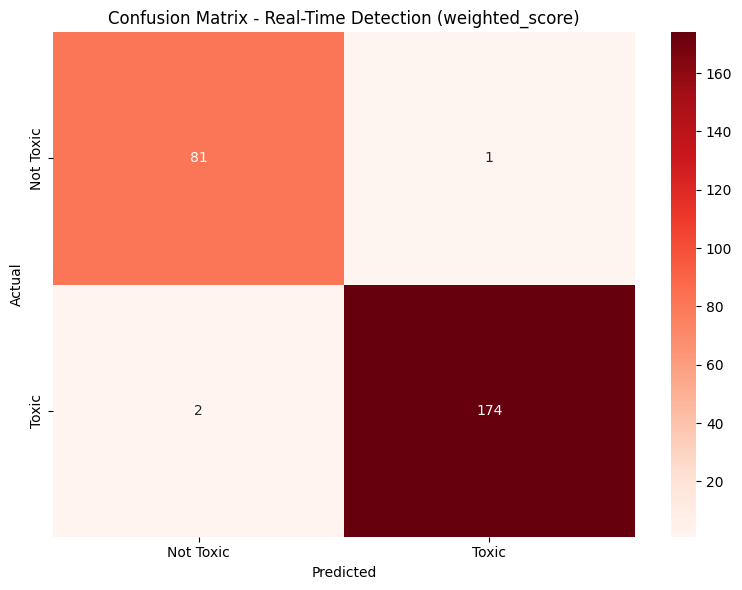


📊 WEIGHTED SCORE DETECTION RESULTS
Detection Method: WEIGHTED_SCORE
📊 Accuracy: 0.9884
🎯 Precision: 0.9943
📈 Recall: 0.9886
⚖️  F1-Score: 0.9915
⏱️  Processing Time: 22.82 seconds

✅ Real-time toxicity detection analysis completed!
📊 Total conversations analyzed: 258
🎯 Weighted Score F1-Score: 0.9915


In [70]:
print("REAL TIME DETECTION OF TOXIC CONVERSATIONS")
model_loaded, tokenizer_loaded, label_encoder_loaded, metadata = load_personality_classifier("personality_classifier_best")
# Load dataset (same as before)
dataset = pd.read_csv("dataset_clean_with_personality_tags.csv", encoding='utf-8')
print(f"Dataset loaded: {len(dataset)} conversations")

# Split dataset into train and test sets
print(f"\n🔄 Splitting dataset...")
X_train, X_test, y_train, y_test = train_test_split(
    dataset['conversation'],
    dataset['toxic'],
    test_size=0.3,
    random_state=seed,
    shuffle=True
)


# Define personality types (same as before)
personality_descriptions = {
    'PSICOPATICO': "Una persona che manipola senza empatia in modo freddo e calcolato",
    'ADULATRICE': "Una persona che elogia eccessivamente, lusinga in modo servile e compiacente per ottenere favori", 
    'MANIPOLATORE': "Una persona che manipola psicologicamente gli altri per ottenere vantaggi personali",
    'DIPENDENTE_EMOTIVA': "Una persona che dipende eccessivamente dagli altri per il supporto emotivo e la validazione",
    'PERSONA_VIOLENTA': "Una persona che usa aggressività verbale, minacce o comportamenti intimidatori",
    'SUCCUBE': "Una persona completamente dominata e sottomessa, che subisce senza reagire",
    'NARCISISTA': "Una persona con senso grandioso di sé, mancanza di empatia e bisogno di ammirazione",
    'SADICO_CRUDELE': "Una persona che trae piacere dal causare sofferenza fisica o psicologica altrui",
    'MASOCHISTA': "Una persona che cerca o accetta sofferenza, umiliazione e trattamenti negativi",
    'PERFEZIONISTA_CRITICO': "Una persona che critica tutto e ha standard impossibili da raggiungere",
    'INSICURA_CRONICA': "Una persona che mostra insicurezza costante, mancanza di autostima e bisogno di rassicurazione",
    'VITTIMISTA': "Una persona che si presenta sempre come vittima delle circostanze",
    'CROCCEROSSINA': "Una persona che ha un bisogno compulsivo di salvare e aiutare gli altri, anche quando non richiesto",
    'DOMINANTE': "Una persona che impone la propria volontà in modo autoritario e aggressivo",
    'SCHIAVO_EMOTIVO': "Una persona completamente sottomessa emotivamente, senza autonomia personale",
    'GELOSO_OSSESSIVO': "Una persona che manifesta gelosia patologica e comportamenti ossessivi possessivi",
    'SOTTOMESSA': "Una persona che si sottomette passivamente agli altri senza esprimere opinioni proprie",
    'CONTROLLORE': "Una persona che cerca di dominare e controllare gli altri in modo manipolativo e autoritario",
    'ISOLATA': "Una persona che si ritira socialmente, evita il contatto e preferisce la solitudine",
    'PREOCCUPATO': "Una persona che mostra ansia, preoccupazione e stress costanti",
    'RASSICURANTE': "Una persona che tranquillizza e conforta gli altri in modo sano e costruttivo",
    'ENTUSIASTA': "Una persona che mostra energia, passione e entusiasmo positivi",
    'SOSTENITORE': "Una persona che supporta gli altri in modo costruttivo, sano e incoraggiante",
    'AFFETTUOSO': "Una persona che mostra calore, tenerezza e affetto genuino verso gli altri",
    'RISPETTOSO': "Una persona che mostra considerazione, cortesia e rispetto genuino per gli altri",
    'TRANQUILLO': "Una persona calma, equilibrata emotivamente e pacifica",
    'CONFORTANTE': "Una persona che offre consolazione, supporto emotivo e comfort agli altri"
}

print("🚨 REAL TIME DETECTION OF TOXIC CONVERSATIONS 🚨")
print("="*60)

# Load the fine-tuned model
model_loaded, tokenizer_loaded, label_encoder_loaded, metadata = load_personality_classifier("personality_classifier_best")

# Load dataset for testing real-time detection
dataset = pd.read_csv("dataset_clean_with_personality_tags.csv", encoding='utf-8')
print(f"Dataset loaded: {len(dataset)} conversations")

# Split dataset into train and test sets
print(f"\n🔄 Splitting dataset for real-time testing...")
X_train, X_test, y_train, y_test = train_test_split(
    dataset['conversation'],
    dataset['toxic'],
    test_size=0.3,
    random_state=seed,
    shuffle=True
)

print(f"Test set size: {len(X_test)} conversations")

# Define toxic personality types (these indicate potentially harmful behavior)
toxic_personalities = {
    'PSICOPATICO', 'ADULATRICE', 'MANIPOLATORE', 'DIPENDENTE_EMOTIVA',
    'PERSONA_VIOLENTA', 'SUCCUBE', 'NARCISISTA', 'SADICO_CRUDELE',
    'MASOCHISTA', 'PERFEZIONISTA_CRITICO', 'INSICURA_CRONICA',
    'VITTIMISTA', 'CROCCEROSSINA', 'DOMINANTE', 'SCHIAVO_EMOTIVO',
    'GELOSO_OSSESSIVO', 'SOTTOMESSA', 'CONTROLLORE', 'ISOLATA'
}

# Define healthy personality types (all others not in toxic list)
healthy_personalities = {
    'PREOCCUPATO', 'RASSICURANTE', 'ENTUSIASTA', 'SOSTENITORE', 
    'AFFETTUOSO', 'RISPETTOSO', 'TRANQUILLO', 'CONFORTANTE'
}

print(f"\n🔍 Toxic personalities identified: {len(toxic_personalities)}")
print(f"📝 Healthy personalities identified: {len(healthy_personalities)}")

def predict_single_message_personality(message, conversation_context, model, tokenizer, label_encoder, max_length=512):
    """
    Predict personality for a single message with conversation context.
    """
    device = next(model.parameters()).device
    
    # Build context text (same as training)
    if conversation_context:
        context_parts = []
        for ctx in conversation_context:
            context_parts.append(f"{ctx['message']} [{ctx['personality']}]")
        context_text = " ".join(context_parts) + " " + message
    else:
        context_text = message
    
    # Tokenize
    encoding = tokenizer(
        context_text,
        truncation=True,
        max_length=max_length,
        padding='max_length',
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probabilities = F.softmax(outputs, dim=1)
        predicted_class = torch.argmax(outputs, dim=1).cpu().numpy()[0]
        confidence = torch.max(probabilities, dim=1)[0].cpu().numpy()[0]
        
    predicted_personality = label_encoder.inverse_transform([predicted_class])[0]
    
    return predicted_personality, confidence

def real_time_toxicity_detection(conversation, model, tokenizer, label_encoder, 
                                 detection_criteria='immediate_toxic', 
                                 toxic_threshold=0.6, verbose=False):
    """
    Real-time toxicity detection with multiple criteria.
    
    Parameters:
    - detection_criteria: 
        'immediate_toxic': Mark as toxic immediately when toxic personality detected
        'consecutive_toxic': Mark as toxic after 2 consecutive toxic messages
        'ratio_based': Mark as toxic if >50% of messages are toxic
        'weighted_score': Use confidence-weighted scoring
    - toxic_threshold: Confidence threshold for toxic detection
    """
    
    # Extract messages from conversation
    messages = extract_messages_from_conversation(conversation)
    if len(messages) < 2:
        return 0, [], "Conversation too short"
    
    conversation_context = []
    personality_predictions = []
    toxic_messages = 0
    consecutive_toxic = 0
    max_consecutive_toxic = 0
    toxic_score = 0.0
    is_toxic = False
    detection_reason = ""
    
    for i, message in enumerate(messages):
        # Predict personality for current message
        personality, confidence = predict_single_message_personality(
            message, conversation_context, model, tokenizer, label_encoder
        )
        
        personality_predictions.append({
            'message_id': i,
            'message': message[:50] + "..." if len(message) > 50 else message,
            'personality': personality,
            'confidence': confidence,
            'is_toxic': personality in toxic_personalities
        })
        
        # Check if current message is toxic
        is_message_toxic = personality in toxic_personalities
        
        if is_message_toxic:
            toxic_messages += 1
            consecutive_toxic += 1
            max_consecutive_toxic = max(max_consecutive_toxic, consecutive_toxic)
            toxic_score += confidence
        else:
            consecutive_toxic = 0
            if personality in healthy_personalities:
                toxic_score -= confidence * 0.5  # Reduce toxic score for healthy messages
        
        # Apply detection criteria - ONLY WEIGHTED SCORE
        if detection_criteria == 'weighted_score':
            avg_toxic_score = toxic_score / (i + 1)
            if avg_toxic_score > toxic_threshold:
                is_toxic = True
                detection_reason = f"Weighted toxic score exceeded: {avg_toxic_score:.3f}"
                if verbose:
                    print(f"🚨 TOXIC DETECTED: Weighted score {avg_toxic_score:.3f}")
                break
        
        # Add to conversation context
        conversation_context.append({
            'message': message,
            'personality': personality
        })
    
    if not is_toxic:
        detection_reason = "No toxicity detected - conversation completed safely"
        if verbose:
            print("✅ Conversation completed - NO TOXICITY DETECTED")
    
    return int(is_toxic), personality_predictions, detection_reason

def evaluate_real_time_detection(X_test, y_test, model, tokenizer, label_encoder, 
                                detection_criteria='immediate_toxic', 
                                toxic_threshold=0.6, verbose_sample=5):
    """
    Evaluate real-time detection system on test set.
    """
    print(f"\n🧪 Evaluating Real-Time Detection System")
    print(f"📊 Detection Criteria: {detection_criteria}")
    print(f"🎯 Toxic Threshold: {toxic_threshold}")
    print(f"📝 Test Conversations: {len(X_test)}")
    print("-" * 50)
    
    predictions = []
    actual_labels = list(y_test)
    detailed_results = []
    
    start_time = time.time()
    
    for idx, (conversation, actual_label) in enumerate(zip(X_test, y_test)):
        if idx < verbose_sample:
            verbose = True
            print(f"\n🔍 Processing Conversation {idx + 1}:")
            print(f"Actual label: {'TOXIC' if actual_label == 1 else 'NOT TOXIC'}")
            print("-" * 30)
        else:
            verbose = False
            
        prediction, personality_details, reason = real_time_toxicity_detection(
            conversation, model, tokenizer, label_encoder, 
            detection_criteria, toxic_threshold, verbose
        )
        
        predictions.append(prediction)
        
        detailed_results.append({
            'conversation_id': idx,
            'actual': actual_label,
            'predicted': prediction,
            'detection_reason': reason,
            'personality_sequence': [p['personality'] for p in personality_details],
            'num_messages': len(personality_details)
        })
        
        if verbose:
            print(f"Final Decision: {'TOXIC' if prediction == 1 else 'NOT TOXIC'}")
            print(f"Correct: {'✅' if prediction == actual_label else '❌'}")
            print(f"Reason: {reason}")
            
        # Progress indicator
        if (idx + 1) % 50 == 0:
            print(f"\n📈 Processed {idx + 1}/{len(X_test)} conversations")
            
        # Clear GPU memory periodically
        if (idx + 1) % 100 == 0:
            torch.cuda.empty_cache()
    
    end_time = time.time()
    processing_time = end_time - start_time
    
    # Calculate metrics
    accuracy = accuracy_score(actual_labels, predictions)
    precision = precision_score(actual_labels, predictions, zero_division=0)
    recall = recall_score(actual_labels, predictions, zero_division=0)
    f1 = f1_score(actual_labels, predictions, zero_division=0)
    cm = confusion_matrix(actual_labels, predictions)
    
    print(f"\n" + "="*60)
    print(f"🎯 REAL-TIME DETECTION RESULTS - {detection_criteria.upper()}")
    print(f"="*60)
    print(f"⏱️  Processing Time: {processing_time:.2f} seconds")
    print(f"🚀 Average Time per Conversation: {processing_time/len(X_test):.3f} seconds")
    print(f"📊 Accuracy: {accuracy:.4f}")
    print(f"🎯 Precision: {precision:.4f}")
    print(f"📈 Recall: {recall:.4f}")
    print(f"⚖️  F1-Score: {f1:.4f}")
    
    # Additional statistics
    total_toxic_actual = sum(actual_labels)
    total_toxic_predicted = sum(predictions)
    print(f"\n📊 DETECTION STATISTICS:")
    print(f"   • Actual Toxic Conversations: {total_toxic_actual}/{len(actual_labels)} ({total_toxic_actual/len(actual_labels)*100:.1f}%)")
    print(f"   • Predicted Toxic Conversations: {total_toxic_predicted}/{len(predictions)} ({total_toxic_predicted/len(predictions)*100:.1f}%)")
    
    # Show confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
                xticklabels=['Not Toxic', 'Toxic'], 
                yticklabels=['Not Toxic', 'Toxic'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - Real-Time Detection ({detection_criteria})')
    plt.tight_layout()
    plt.savefig(f"confusion_matrix_realtime_{detection_criteria}.png")
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'processing_time': processing_time,
        'detailed_results': detailed_results,
        'predictions': predictions,
        'actual_labels': actual_labels
    }

# Test only weighted_score detection criteria
detection_methods = [
    ('weighted_score', 0.3)
    # in case you want to test other methods, you can add them here
]

results_comparison = {}

for criteria, threshold in detection_methods:
    print(f"\n{'='*80}")
    print(f"🧪 TESTING DETECTION METHOD: {criteria.upper()}")
    print(f"{'='*80}")
    
    results = evaluate_real_time_detection(
        X_test, y_test, model_loaded, tokenizer_loaded, label_encoder_loaded,
        detection_criteria=criteria, 
        toxic_threshold=threshold,
        verbose_sample=5  # Show details for first 5 conversations
    )
    
    results_comparison[criteria] = results

# Show results for the single method
print(f"\n{'='*80}")
print(f"📊 WEIGHTED SCORE DETECTION RESULTS")
print(f"{'='*80}")

method = 'weighted_score'
result = results_comparison[method]

print(f"Detection Method: {method.upper()}")
print(f"📊 Accuracy: {result['accuracy']:.4f}")
print(f"🎯 Precision: {result['precision']:.4f}")
print(f"📈 Recall: {result['recall']:.4f}")
print(f"⚖️  F1-Score: {result['f1_score']:.4f}")
print(f"⏱️  Processing Time: {result['processing_time']:.2f} seconds")

print(f"\n✅ Real-time toxicity detection analysis completed!")
print(f"📊 Total conversations analyzed: {len(X_test)}")
print(f"🎯 Weighted Score F1-Score: {result['f1_score']:.4f}")

